iter 0, log-likelihood = -2513.8645
iter 10, log-likelihood = -2475.0171
iter 20, log-likelihood = -2474.8413
iter 30, log-likelihood = -2474.8379
iter 40, log-likelihood = -2474.8342
iter 50, log-likelihood = -2474.8304
iter 60, log-likelihood = -2474.8263
iter 70, log-likelihood = -2474.8220
iter 80, log-likelihood = -2474.8175
iter 90, log-likelihood = -2474.8128
iter 100, log-likelihood = -2474.8080
iter 110, log-likelihood = -2474.8029
iter 120, log-likelihood = -2474.7978
iter 130, log-likelihood = -2474.7925
iter 140, log-likelihood = -2474.7872
iter 150, log-likelihood = -2474.7817
iter 160, log-likelihood = -2474.7763
iter 170, log-likelihood = -2474.7707
iter 180, log-likelihood = -2474.7652
iter 190, log-likelihood = -2474.7596

--- EM Gaussian Mixture Summary ---

Component 0:
  Weight = 0.4872
  Mean = [133.3981759066096]
  Covariance = 
[[6675.28309036]]

Component 1:
  Weight = 0.5128
  Mean = [372.46024495374246]
  Covariance = 
[[6123.04226223]]


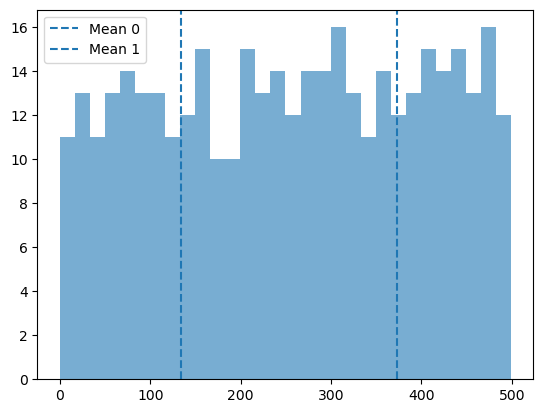

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, pi

# ---------- Load CSV ----------
df = pd.read_csv("../Dataset/lmsys_chat_500_cleaned.csv")

# Use numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.values.astype(float)
n, d = X.shape

# ---------- Helper: log multivariate Gaussian ----------
def log_multivariate_normal_pdf(x, mean, cov):
    x_m = x - mean
    sign, logdet = np.linalg.slogdet(cov)
    if sign != 1:
        cov = cov + np.eye(cov.shape[0]) * 1e-6
        sign, logdet = np.linalg.slogdet(cov)
    inv_cov = np.linalg.inv(cov)
    if x.ndim == 1:
        quad = x_m.T.dot(inv_cov).dot(x_m)
        return -0.5 * (d * log(2 * pi) + logdet + quad)
    else:
        quad = np.einsum('ij,ij->i', x_m.dot(inv_cov), x_m)
        return -0.5 * (d * log(2 * pi) + logdet + quad)

# ---------- EM algorithm ----------
def run_em(X, K=2, max_iter=200, tol=1e-6, verbose=True):
    n, d = X.shape
    rng = np.random.RandomState(0)
    means = X[rng.choice(n, K, replace=False)]
    covs = np.array([np.cov(X, rowvar=False) + np.eye(d)*1e-6 for _ in range(K)])
    weights = np.ones(K) / K
    log_likelihoods = []

    for it in range(max_iter):
        # E-step
        log_resp = np.zeros((n, K))
        for k in range(K):
            log_resp[:, k] = np.log(weights[k] + 1e-16) + log_multivariate_normal_pdf(X, means[k], covs[k])

        max_log = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log)
        resp /= resp.sum(axis=1, keepdims=True)

        Nk = resp.sum(axis=0)
        # M-step
        weights = Nk / n
        means = (resp.T @ X) / Nk[:, np.newaxis]
        for k in range(K):
            diff = X - means[k]
            covs[k] = (diff * resp[:, k][:, np.newaxis]).T @ diff / Nk[k]
            covs[k] += np.eye(d) * 1e-6

        ll = np.sum(np.log(np.sum(np.exp(log_resp - max_log), axis=1)) + max_log.ravel())
        log_likelihoods.append(ll)

        if verbose and it % 10 == 0:
            print(f"iter {it}, log-likelihood = {ll:.4f}")

        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return {"weights": weights, "means": means, "covariances": covs, 
            "responsibilities": resp, "log_likelihoods": log_likelihoods}

# ---------- Run EM ----------
K = 2  # number of mixture components
result = run_em(X, K=K)

weights = result["weights"]
means = result["means"]
covs = result["covariances"]
resp = result["responsibilities"]

# ---------- Show results ----------
print("\n--- EM Gaussian Mixture Summary ---")
for k in range(K):
    print(f"\nComponent {k}:")
    print(f"  Weight = {weights[k]:.4f}")
    print(f"  Mean = {means[k].tolist()}")
    print(f"  Covariance = \n{covs[k]}")

# ---------- Plot ----------
if d >= 2:
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(resp, axis=1), s=20)
    plt.xlabel(numeric_df.columns[0])
    plt.ylabel(numeric_df.columns[1])
    plt.title("GMM clustering (K=2)")
else:
    plt.hist(X[:, 0], bins=30, alpha=0.6)
    for k in range(K):
        plt.axvline(means[k, 0], linestyle='--', label=f'Mean {k}')
    plt.legend()
plt.show()
